In [406]:
#libraries
#import igor.igorpy as igor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from natsort import natsorted

#%matplotlib inline

# Functions

In [399]:
#Fxn to select waves for analysis
def indexWaves(df) :
    igorWaves = df.pivot(index='sec', columns='id', values='pA')
    waves = igorWaves.filter(waveInfo['waveName'])
    waves = waves.dropna(axis = 0)
    return(waves)

#Fxn to normalize traces
def normalizeTraces(df) :
    baseline = df[endCap:firstArtBegin]
    baseline = baseline.dropna(axis = 0)
    avgBaseline = baseline.apply(np.mean, axis = 0)
    normalizedTraces = df - avgBaseline
    return(normalizedTraces)

#Fxn to select specific traces by notes column
def wavesByNotes(df, info) :
    notesColumn = waveInfo.loc[:,['waveName', 'notes']]
    selectWaves = notesColumn.loc[notesColumn['notes'] == info]
    finalWaves = df.filter(selectWaves['waveName'])
    return(finalWaves)

#Fxn to remove waves before bicuculline, test waves, NMDA tau wave
def removeBicTestTau(df) :
    toRemove1 = list(wavesByNotes(df, info = 'noBic').columns.values)
    toRemove2 = list(wavesByNotes(df, info = 'test').columns.values)
    toRemove3 = list(wavesByNotes(df, info = 'NMDA tau').columns.values)
    toRemove = toRemove1 + toRemove2 + toRemove3
    df = df.drop(toRemove, 1)
    return(df)

#Fxn to find paired pulse ratio (second AMPA response / first AMPA response)
def findPPR(df1, df2) :
    #all AMPA amplitudes
    amplitudes = df1.apply(min)
    
    #identify waveName of max AMPA trace and select that wave
    findAMPAtrace = amplitudes[amplitudes.isin([min(amplitudes)])]
    findAMPAtrace = findAMPAtrace.dropna(axis = 0)
    maxAMPAtrace = df2.filter(findAMPAtrace.index)
    
    #calculate amplitude of second AMPA response
    secAMPAtrace = maxAMPAtrace[secStimBegin:secStimEnd]
    secAMPA = min(secAMPAtrace.apply(min))
    
    PPR = secAMPA / min(amplitudes)
    return(PPR)

#Fxn to pull out tau trace
def findTauTrace(df) :
    igorWaves = df.pivot(index='sec', columns='id', values='pA')
    notesColumn = waveInfo.loc[:,['waveName', 'notes']]
    selectWaves = notesColumn.loc[notesColumn['notes'] == 'NMDA tau']
    tauTrace = igorWaves.filter(selectWaves['waveName'])
    tauTrace = tauTrace.dropna(axis = 0)
    tauTrace = tauTrace[firstStimBegin:endTauTrace]
    tauTrace[firstArtBegin:firstArtEnd] = np.nan
    return(tauTrace)

# Time points

In [5]:
#####Change to class?

#artifacts
firstArtBegin = 0.081 
firstArtEnd = 0.0845 #generally 0.0845
secArtBegin = 0.131
secArtEnd = 0.134

#time points of traces for analysis
endCap = 0.02
firstStimBegin = 0.08
firstStimEnd = 0.125
secStimBegin = 0.136
secStimEnd = 0.175

#time points for finding NMDA decay time
endTauTrace = 0.58
beginTau = 0.115
endTau = 0.5

#for finding tau of capacitance traces
beginCapCurve = 0.00565
endCapCurve = 0.011
beginCapBaseline = 0.010
tauThreshold = 0.001

# Load experimental files and information

In [503]:
#load excel file
waveInfo = pd.read_excel('2016.10.26_Cell1.xlsx')
waveInfo.head()

,waveNum,waveName,stimInt,notes
0,1,w7,40.0,noBic
1,2,w8,40.0,noBic
2,3,w9,40.0,noBic
3,4,w10,40.0,noBic
4,5,w11,40.0,noBic


In [375]:
#cell information
date = '2016.10.26'
cellNum = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)

#Reformat and select waves in waveInfo
allWaves = indexWaves(igor)
allWaves.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


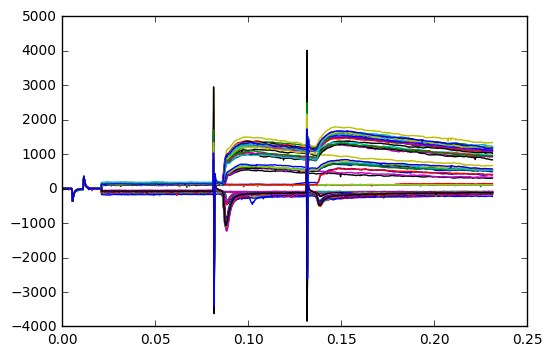

In [9]:
plt.plot(allWaves)
plt.show()

# Capacitance decay

Identify and remove waves where the capacitance decay time is above a particular threshold

In [367]:
capCurve = allWaves[beginCapCurve:endCapCurve]

#normalize each cap trace to zero
normalizeCap = capCurve - np.mean(capCurve[beginCapBaseline:endCapCurve]) + 1.0e-10

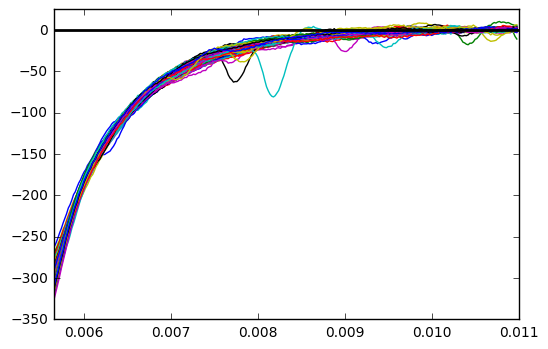

In [368]:
x = normalizeCap
fig, ax = plt.subplots()
ax.plot(x)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([beginCapCurve, endCapCurve, -350, 25])
plt.show()

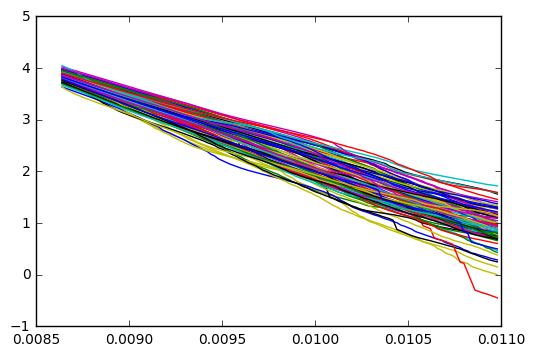

In [276]:
#Take log of amplitudes so can fit a linear model to cap traces
capLog = np.log(abs(normalizeCap))
smoothCurve = capLog.rolling(window = 150).mean()

plt.plot(smoothCurve)
plt.show()

In [421]:
tracesForReg = smoothCurve.reset_index()
regModel = {}
for colname in tracesForReg.drop('sec', axis=1).columns:
    model = smf.ols(formula=colname+' ~ sec', data=tracesForReg)
    regModel[colname] = model.fit()

#regModel['w7'].params

Intercept      13.84659
sec         -1149.91073
dtype: float64

In [481]:
#Pull out coefficients of each trace
coefs = []
ids = []
for key in regModel:
    id = key
    ids.append(id)
    coef = regModel[key].params
    coefs.append(coef)

coefs = pd.DataFrame(coefs, index = natsorted(ids))
coefs.head()

,Intercept,sec
w7,14.674996,-1272.069704
w8,13.415283,-1092.467279
w9,14.528275,-1213.540703
w10,13.745824,-1142.077453
w11,12.372815,-980.678960


In [483]:
#Calculate all capacitance taus (small tau = fast decay)
decayTimes = coefs.drop('Intercept', 1)
decayTimes = abs(1 / decayTimes)
decayTimes.head()

,sec
w7,0.000786
w8,0.000915
w9,0.000824
w10,0.000876
w11,0.001020


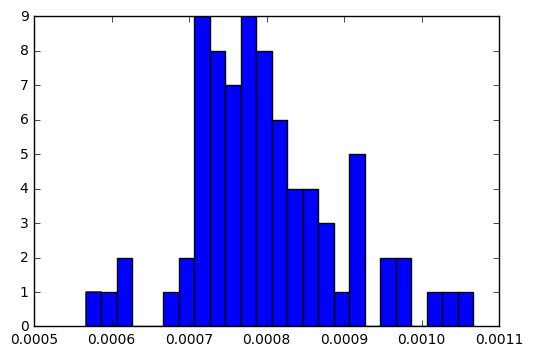

In [293]:
plt.hist(decayTimes['sec'], bins = 25)
plt.show()

# Identify threshold for decay of AMPA waves; filter out waves

# Analysis of waves

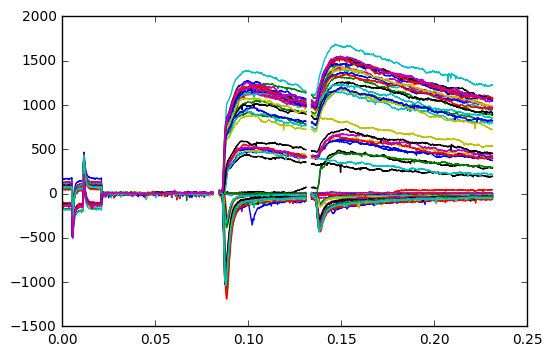

In [414]:
#Filter out waves with cap decay > threshold
##IF STATEMENT (OR FOR LOOP) TO REMOVE ODD ROW IF EVEN IS TOO SLOW AND VICE VERSA?
wavesToAnalyze = allWaves.filter((decayTimes[decayTimes['sec'] <= tauThreshold]).index)

#remove stimulus artifacts
wavesToAnalyze[firstArtBegin:firstArtEnd] = np.nan
wavesToAnalyze[secArtBegin:secArtEnd] = np.nan

#normalize traces
normalized = normalizeTraces(wavesToAnalyze)
plt.plot(normalized)
plt.show()

In [519]:
#break data into different sections for analysis/plotting

cap = wavesToAnalyze[0:endCap] #cap trace doesn't need to be normalized
firstStim = normalized[firstStimBegin:firstStimEnd]
bothStim = normalized[firstStimBegin:secStimEnd]

#remove waves without bic, test waves, NMDA tau wave 
firstStim = removeBicTestTau(firstStim)
bothStim = removeBicTestTau(bothStim)

In [520]:
#AMPA and NMDA current amplitudes

#maximals
maxNMDA = max(firstStim.apply(max))
maxAMPA = min(firstStim.apply(min))

ANRatio = abs(maxAMPA / maxNMDA)
PPR = findPPR(firstStim, bothStim) #PPR of max AMPA trace only

#SFs
SFs = wavesByNotes(bothStim, info = 'SF')
sfNMDA = max(SFs.apply(max))
sfAMPA = min(SFs.apply(min))

#FFs
FFampa = sfAMPA / maxAMPA
FFnmda = sfNMDA / maxNMDA
FFcell = (FFampa + FFnmda) / 2

# Calculate NMDA decay time (tau)

In [486]:
tauTrace = findTauTrace(igor)
tauTraceNorm = normalizeTraces(tauTrace)

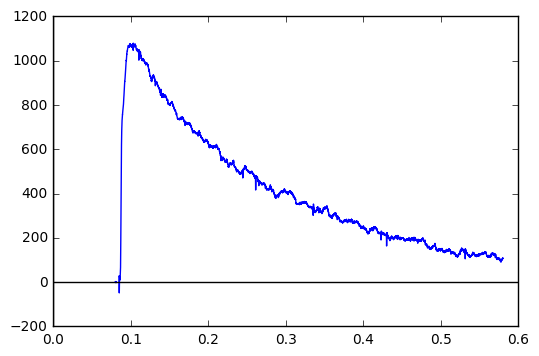

In [488]:
y = tauTraceNorm
fig, ay = plt.subplots()
ay.plot(y)
ay.axhline(y=0, color='k')
ay.axvline(x=0, color='k')
plt.show()

In [349]:
curveToFit = tauTraceNorm[beginTau:endTau]
pA = np.log(np.array(curveToFit.ix[:,0]))
sec = np.array(curveToFit.index)

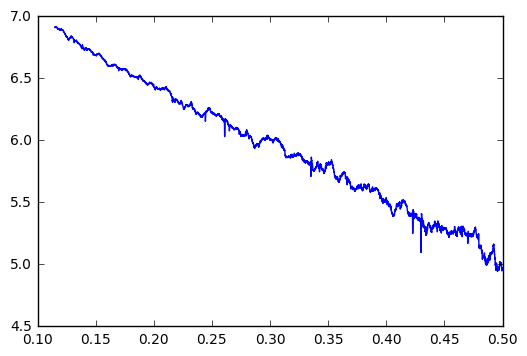

In [387]:
plt.plot(sec, pA)
plt.show()

In [19]:
%load_ext rpy2.ipython


Call:
lm(formula = pA ~ sec)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.275791 -0.024675 -0.000228  0.023171  0.147070 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.387921   0.000853    8661   <2e-16 ***
sec         -4.689412   0.002609   -1798   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04023 on 19249 degrees of freedom
Multiple R-squared:  0.9941,	Adjusted R-squared:  0.9941 
F-statistic: 3.231e+06 on 1 and 19249 DF,  p-value: < 2.2e-16



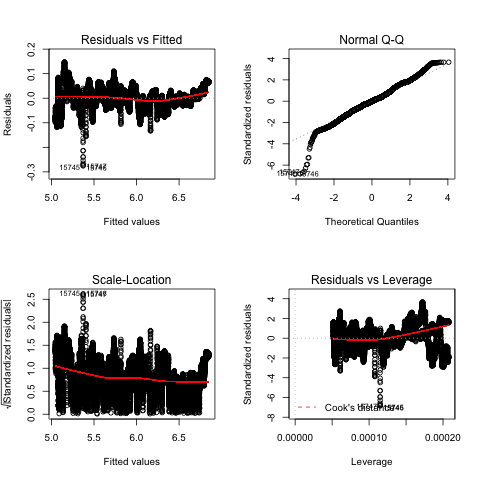

In [350]:
%%R -i pA,sec -o tauCoef
regModel = lm(pA ~ sec)
tauCoef = coef(regModel)
par(mfrow=c(2,2))
plot(regModel)
summary(regModel)

In [351]:
tau = abs(1 / tauCoef[1])
tau

0.21324637034370891

# Store all parameters

In [521]:
#create data frame with all parameters

colNames = ['date', 'cellNum', 'age', 
            'maxAMPA', 'maxNMDA', 'ANRatio', 'PPR',
           'sfAMPA', 'sfNMDA',
           'FFampa', 'FFnmda', 'FFcell', 'tau']

parameters = pd.DataFrame([[date, cellNum, age,
                           maxAMPA, maxNMDA, ANRatio, PPR,
                           sfAMPA, sfNMDA,
                           FFampa, FFnmda, FFcell, tau]], 
                         columns = colNames)

parameters

,date,cellNum,age,maxAMPA,maxNMDA,ANRatio,PPR,sfAMPA,sfNMDA,FFampa,FFnmda,FFcell,tau
0,2016.10.26,1,15,-1189.726536,1389.530604,0.856208,0.362805,-309.773406,489.005228,0.260374,0.351921,0.306147,0.213246


In [24]:
#append each cell as new row in parameters data frame
#for final analysis, filter by age, then calculate means of each column

# Plots of all waves

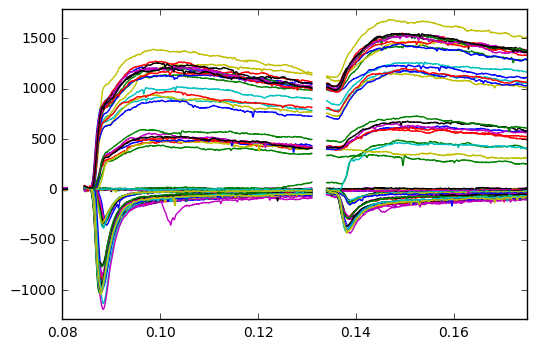

In [524]:
plt.plot(bothStim)
plt.axis([firstStimBegin, secStimEnd, maxAMPA + -100, max(bothStim.apply(max)) + 100])
plt.show()

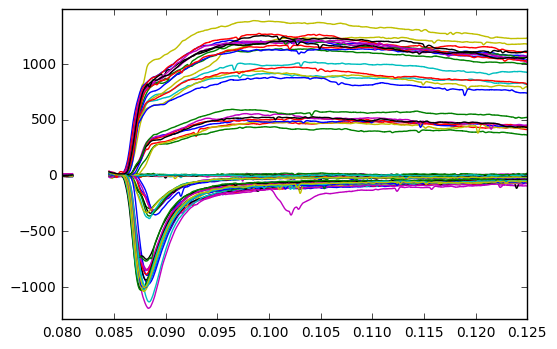

In [523]:
plt.plot(firstStim)
plt.axis([firstStimBegin, firstStimEnd, maxAMPA + -100, maxNMDA + 100])
plt.show()

# Plots of SFs and maximals

Identify maximals automatically by amplitude and plot them - in progress as of 2016.11.10

In [383]:
#select specific traces
#SFs already created in 'Analysis of waves' section
maximals = wavesByNotes(bothStim, info = 'max')
lastMax = wavesByNotes(bothStim, info = 'lastMax')

capSF = wavesByNotes(cap, info = 'SF')
capMax = wavesByNotes(cap, info = 'max')
capLastMax = wavesByNotes(cap, info = 'lastMax')

In [355]:
######
#identify waveName of max traces and select those waves automatically?
    findAMPAtrace = amplitudes[amplitudes.isin([min(amplitudes)])]
ampNMDA = bothStim.apply(max)
testMax = ampNMDA[ampNMDA.isin([maxNMDA])]
testMax

Series([], dtype: float64)

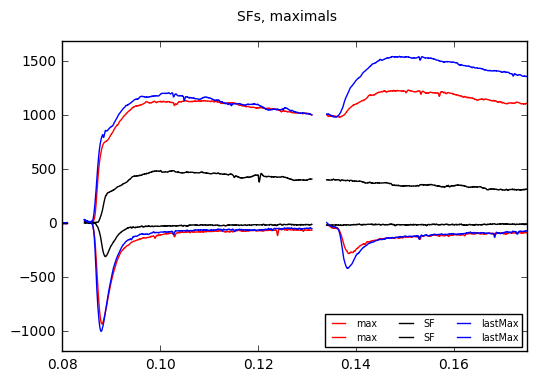

In [391]:
plt.plot(maximals, color = 'r', label = 'max')
plt.plot(SFs, color = 'k', label = 'SF')
plt.plot(lastMax, color = 'b', label = 'lastMax') 
plt.legend(loc = 4, fontsize = 'x-small', ncol = 3)
plt.axis([firstStimBegin, secStimEnd, maxAMPA, max(bothStim.apply(max))])
plt.suptitle('SFs, maximals')
plt.show()

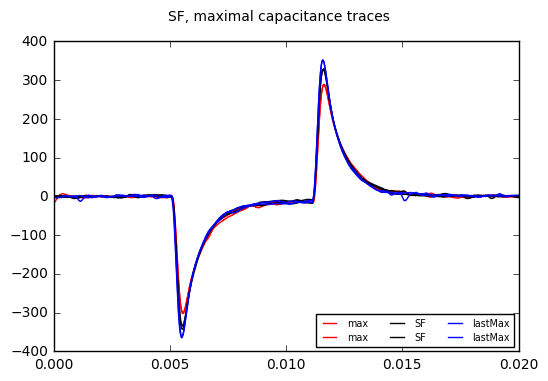

In [385]:
plt.plot(capMax, color = 'r', label = 'max')
plt.plot(capSF, color = 'k', label = 'SF')
plt.plot(capLastMax, color = 'b', label = 'lastMax') 
plt.legend(loc = 4, fontsize = 'x-small', ncol = 3)
plt.axis([0, endCap, -400, 400])
plt.suptitle('SF, maximal capacitance traces')
plt.show()

# Inhibitory traces

Plot waves before bicuculline addition to investigate the presence or absence of inhibitory waves

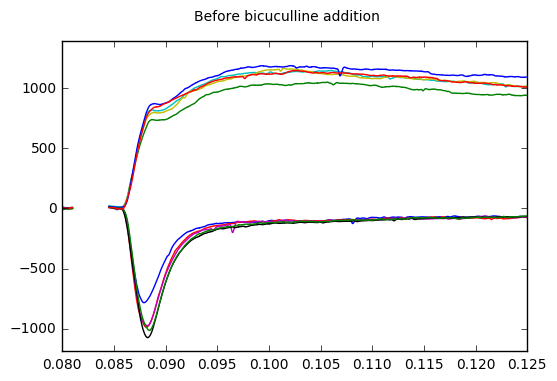

In [489]:
inhTraces = wavesByNotes(firstStim, info = 'noBic')
plt.plot(inhTraces)
plt.suptitle('Before bicuculline addition')
plt.axis([firstStimBegin, firstStimEnd, maxAMPA, maxNMDA])
plt.show()

# Stimulation intensity

Correlate different parameters with stimulation intensity, including PPRs, amplitudes, (integrals?)

Calculate parameters so that waveName = index, parameter = first column, stimInt = second column

How does the response change with increasing stimulation intensity, and does this response change over development?

In [628]:
stimInt = waveInfo.loc[:,['waveName', 'stimInt']]
stimInt = stimInt.set_index('waveName')
stimInt.head()

##When joining stimInt with parameter df (like PPR df)
#join on waveName in parameter df

,stimInt
waveName,
w7,40.0
w8,40.0
w9,40.0
w10,40.0
w11,40.0


# Calculate all PPRs

Combine two for loops below into single if/else statement?

In [627]:
#Find all AMPA pprs (even columns of bothStim)
allPPR_a = []
id_a = []
for wave in bothStim.iloc[:, ::2]:
    id_a.append(wave)
    firstA = min(bothStim[wave][firstStimBegin:firstStimEnd])
    secondA = min(bothStim[wave][secStimBegin:secStimEnd])
    pprA = abs(secondA / firstA)
    allPPR_a.append(pprA)

#Find all NMDA pprs (odd columns of bothStim)
allPPR_n = []
id_n = []
for wave in bothStim.iloc[:, 1::2]:
    id_n.append(wave)
    firstN = max(bothStim[wave][firstStimBegin:firstStimEnd])
    secondN = max(bothStim[wave][secStimBegin:secStimEnd])
    pprN = secondN / firstN
    allPPR_n.append(pprN)

allPPR_a = pd.DataFrame(allPPR_a, index = id_a, columns = ['AMPA PPR'])
allPPR_n = pd.DataFrame(allPPR_n, index = id_n, columns = ['NMDA PPR'])
allPPR_a

##INDICES ARE MESSED UP BECAUSE REMOVED WAVES WITH SLOW CAP

#allPPR = allPPR_a.join(allPPR_n)
#allPPR = pd.DataFrame(allPPR.stack().reset_index(level=[0,1], drop=True), columns = ['PPR'])
#allPPR
#use stack to merge AMPA and NMDA ppr and then index using waveName

,AMPA PPR
w17,0.390442
w19,0.349362
w21,0.350390
w23,0.301431
w27,0.439403
w29,3.056430
w31,0.558634
w33,0.065598
w35,1.354182
w37,1.319929
